In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data = pd.read_csv('/content/drive/MyDrive/Do_an-NCKH/Dataset/spam_ham_dataset.csv')

In [3]:
data

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [4]:
data = data.drop(['Unnamed: 0', 'label'], axis=1)
data.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


Text(0.5, 1.0, 'Spam/ham Data Distribution')

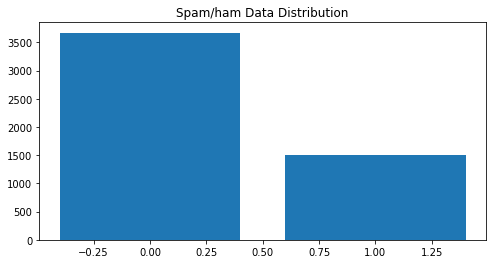

In [5]:
val_count = data.label_num.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Spam/ham Data Distribution")

In [7]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]:\S+|subject:\S+|nbsp"
data.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [8]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [9]:

data.text = data.text.apply(lambda x: preprocess(x))
data.head()

,text,label_num
0,subject: enron methanol ; meter # : 988291 fol...,0
1,"subject: hpl nom january 9 , 2001 ( see attach...",0
2,"subject: neon retreat ho ho ho , ' around wond...",0
3,"subject: photoshop , windows , office . cheap ...",1
4,subject: : indian springs deal book teco pvr r...,0


In [10]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 50
x = data['text']
y = data['label_num']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(x_train))
print("Test Data size", len(x_test))

Train Data size: 4136
Test Data size 1035


# TOKENIZER

In [11]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1000
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 44790


In [12]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(x_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (4136, 50)
Testing X Shape: (1035, 50)


# LSTM

In [13]:
#LSTM hyperparameters
n_lstm = 200
drop_lstm =0.2


In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [15]:
embeding_dim = 16


In [16]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=MAX_SEQUENCE_LENGTH))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [17]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(x_train, y_train, epochs=num_epochs, 
                    validation_data=(x_test, y_test),callbacks =[early_stop], verbose=2)

Epoch 1/30
130/130 - 20s - loss: 0.3171 - accuracy: 0.8647 - val_loss: 0.1063 - val_accuracy: 0.9703
Epoch 2/30
130/130 - 16s - loss: 0.0429 - accuracy: 0.9878 - val_loss: 0.1316 - val_accuracy: 0.9713
Epoch 3/30
130/130 - 16s - loss: 0.0312 - accuracy: 0.9945 - val_loss: 0.0947 - val_accuracy: 0.9756
Epoch 4/30
130/130 - 16s - loss: 0.0086 - accuracy: 0.9986 - val_loss: 0.1139 - val_accuracy: 0.9783
Epoch 5/30
130/130 - 16s - loss: 0.0143 - accuracy: 0.9977 - val_loss: 0.2058 - val_accuracy: 0.9623


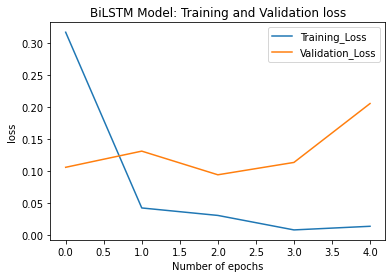

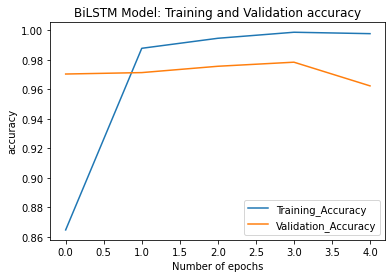

In [18]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# PPDL

In [19]:
model1 = Sequential()
model1.add(model2.layers[0])


In [20]:
x_input = x_test[0:5]
y_model = model1.predict(x_input) # Dùng để so sánh kết quả

## Server

In [21]:
model = Sequential()
for layer in model2.layers[1:]:
  model.add(layer)
model.build(input_shape = model2.layers[0].output_shape)

In [22]:
lstW = model2.layers[0].get_weights()[0] #Lấy weight của layer 0
lstW.shape

(44790, 16)

In [23]:
k = np.random.rand(2,2).astype(np.float32)
kd = np.linalg.inv(k)

In [24]:
lk = []
for i in range(lstW.shape[0]):
  wi = lstW[i,:]
  w_plus = np.random.uniform(-1, 1, len(wi)).astype(np.float32)
  w_ = np.array([wi, w_plus])
  lk.append(k.dot(w_))
#Tạo nhiễu và nhân với khóa K để khi gửi về Client không bị lộ Weight
LW = tf.convert_to_tensor(lk)

In [25]:
LW.shape

TensorShape([44790, 2, 16])

## Client

In [26]:
X = np.zeros((x_input.shape[0], x_input.shape[1], 2))
for i in range(X.shape[0]):
  X_ = []
  for j in x_input[i]:
    x_ = np.random.randint(0, LW.shape[0])
    xx = [j, x_]
    X_.append(xx)
    j += 1
  X[i] = X_
#Tạo nhiễu cho Input

In [27]:
X_one_hot = tf.one_hot(X, LW.shape[0]) 
Y0 = X_one_hot@LW[:,0]
Y1 = X_one_hot@LW[:,1]

In [28]:
Y = np.zeros_like(Y0)
for i in range(Y0.shape[0]):
  for j in range(Y0.shape[1]):
    Y[i,j,0] = Y0[i,j,0]
    Y[i,j,1] = Y1[i,j,0]
Y = tf.convert_to_tensor(Y)

In [29]:
Y.shape

TensorShape([5, 50, 2, 16])

## Serer

In [30]:
lstY = []
for i in range(Y.shape[0]):
  lst = []
  for j in range(Y.shape[1]):
    y_ = kd@Y[i,j]
    lst.append(y_[0]) 
  lstY.append(lst)
lstY = tf.convert_to_tensor(lstY)

In [31]:
model.predict(lstY)[0]

array([[0.9964959 ],
       [0.99758184],
       [0.99834263],
       [0.9987738 ],
       [0.99880624],
       [0.9987504 ],
       [0.999037  ],
       [0.99931854],
       [0.9994867 ],
       [0.9994354 ],
       [0.9995489 ],
       [0.9996524 ],
       [0.9996232 ],
       [0.99964225],
       [0.9996158 ],
       [0.9997346 ],
       [0.99978805],
       [0.99985325],
       [0.99987954],
       [0.999912  ],
       [0.9999109 ],
       [0.99993736],
       [0.9999577 ],
       [0.99997   ],
       [0.9999724 ],
       [0.9999788 ],
       [0.99998176],
       [0.999984  ],
       [0.9999808 ],
       [0.9999763 ],
       [0.9999797 ],
       [0.99997383],
       [0.999964  ],
       [0.99996364],
       [0.99993765],
       [0.9999167 ],
       [0.99988997],
       [0.999854  ],
       [0.99979806],
       [0.99974525],
       [0.99971104],
       [0.9995435 ],
       [0.9995279 ],
       [0.9993092 ],
       [0.9992585 ],
       [0.9991989 ],
       [0.9989644 ],
       [0.998

In [32]:
model2.predict(x_input)[0]

array([[0.9964959 ],
       [0.99758184],
       [0.99834263],
       [0.99877375],
       [0.9988062 ],
       [0.9987504 ],
       [0.999037  ],
       [0.99931854],
       [0.9994867 ],
       [0.9994354 ],
       [0.9995489 ],
       [0.99965227],
       [0.9996232 ],
       [0.99964225],
       [0.9996158 ],
       [0.9997346 ],
       [0.99978805],
       [0.99985325],
       [0.99987954],
       [0.999912  ],
       [0.9999109 ],
       [0.99993736],
       [0.9999577 ],
       [0.99997   ],
       [0.9999724 ],
       [0.9999788 ],
       [0.99998176],
       [0.99998415],
       [0.9999808 ],
       [0.9999763 ],
       [0.9999797 ],
       [0.99997383],
       [0.999964  ],
       [0.99996364],
       [0.99993765],
       [0.9999167 ],
       [0.99988997],
       [0.999854  ],
       [0.99979806],
       [0.99974525],
       [0.99971104],
       [0.9995435 ],
       [0.9995279 ],
       [0.9993092 ],
       [0.99925864],
       [0.999199  ],
       [0.9989644 ],
       [0.998

In [33]:
#Check xong, 2 kết qủa dự đoán đều giông nhau. 